In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy.sparse import csr_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_PATH = './data/'
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

In [3]:
NB15_FEATURES = 'UNSW-NB15_features-modified.csv'

In [4]:
metadata = pd.read_csv(DATA_PATH + TRAIN_PATH + NB15_FEATURES)

metadata

,No.,Name,Type,Description,feature_type
0,5,proto,nominal,Transaction protocol,flow
1,6,state,nominal,Indicates to the state and its dependent proto...,basic
2,7,dur,Float,Record total duration,basic
3,8,sbytes,Integer,Source to destination transaction bytes,basic
4,9,dbytes,Integer,Destination to source transaction bytes,basic
5,10,sttl,Integer,Source to destination time to live value,basic
6,11,dttl,Integer,Destination to source time to live value,basic
7,12,sloss,Integer,Source packets retransmitted or dropped,basic
8,13,dloss,Integer,Destination packets retransmitted or dropped,basic
9,14,service,nominal,"http, ftp, smtp, ssh, dns, ftp-data ,irc and ...",basic


In [5]:
ADDITIONAL_FEATURES_TRAIN = 'additional_features_train.csv'
BASIC_FEATURES_TRAIN = 'basic_features_train.csv'
CONTENT_FEATURES_TRAIN = 'content_features_train.csv'
FLOW_FEATURES_TRAIN = 'flow_features_train.csv'
LABELS_TRAIN = 'labels_train.csv'
TIME_FEATURES_TRAIN = 'time_features_train.csv'

In [6]:
dataset_paths_train = [
    ADDITIONAL_FEATURES_TRAIN,
    BASIC_FEATURES_TRAIN,
    CONTENT_FEATURES_TRAIN,
    FLOW_FEATURES_TRAIN,
    LABELS_TRAIN,
    TIME_FEATURES_TRAIN
]

In [7]:
all_data_train = [pd.read_csv(DATA_PATH + TRAIN_PATH + dp) for dp in dataset_paths_train]

df_train = all_data_train[0]

for df_i in all_data_train[1:]:
    df_train = pd.merge(df_train, df_i, on='id')

df_train.drop(["label"], axis=1, inplace=True)

df_train

,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,...,response_body_len,proto,attack_cat,sjit,djit,sinpkt,dinpkt,tcprtt,synack,ackdat
0,0.0,0.0,0.0,0.0,0.0,11.0,NaN,5.0,4.0,2.0,...,0.0,tcp,Normal,4449.110313,3234.831566,11.845558,6.261361,NaN,0.000444,0.000114
1,0.0,2.0,0.0,0.0,0.0,10.0,10.0,10.0,10.0,NaN,...,0.0,udp,Generic,0.000000,0.000000,0.009000,0.000000,0.000000,0.000000,NaN
2,0.0,NaN,0.0,0.0,0.0,4.0,4.0,2.0,2.0,1.0,...,0.0,tcp,Exploits,8561.040438,249.950547,165.386453,172.345750,0.158826,0.057902,0.100924
3,0.0,0.0,0.0,0.0,0.0,9.0,9.0,3.0,2.0,2.0,...,0.0,tcp,Normal,4053.086020,2918.730804,8.669644,4.496707,0.000558,0.000448,NaN
4,0.0,0.0,0.0,0.0,0.0,3.0,3.0,4.0,3.0,1.0,...,0.0,udp,Normal,0.000000,0.000000,0.008000,0.007000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.0,2.0,0.0,0.0,0.0,38.0,38.0,32.0,NaN,32.0,...,0.0,udp,Generic,0.000000,0.000000,0.005000,0.000000,0.000000,0.000000,0.000000
175337,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,3.0,NaN,...,NaN,tcp,Exploits,15464.286700,531.848125,193.445428,209.600766,0.066524,0.047738,0.018786
175338,0.0,2.0,0.0,NaN,0.0,33.0,33.0,16.0,16.0,16.0,...,0.0,udp,Generic,0.000000,0.000000,0.008000,0.000000,0.000000,0.000000,0.000000
175339,0.0,2.0,0.0,0.0,0.0,36.0,36.0,NaN,37.0,36.0,...,0.0,udp,Generic,0.000000,0.000000,0.004000,0.000000,0.000000,0.000000,NaN


In [8]:
ADDITIONAL_FEATURES_TEST = 'additional_features_test.csv'
BASIC_FEATURES_TEST = 'basic_features_test.csv'
CONTENT_FEATURES_TEST = 'content_features_test.csv'
FLOW_FEATURES_TEST = 'flow_features_test.csv'
TIME_FEATURES_TEST = 'time_features_test.csv'

In [9]:
dataset_paths_test = [
    ADDITIONAL_FEATURES_TEST,
    BASIC_FEATURES_TEST,
    CONTENT_FEATURES_TEST,
    FLOW_FEATURES_TEST,
    TIME_FEATURES_TEST
]

In [10]:
all_data_test = [pd.read_csv(DATA_PATH + TEST_PATH + dp) for dp in dataset_paths_test]

df_test = all_data_test[0]

for df_i in all_data_test[1:]:
    df_test = pd.merge(df_test, df_i, on='id')

df_test

,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,...,trans_depth,response_body_len,proto,sjit,djit,sinpkt,dinpkt,tcprtt,synack,ackdat
0,0.0,1.0,0.0,0.0,0.0,5.0,5.0,2.0,2.0,2.0,...,0.0,0.0,tcp,2737.954123,118.833969,48.756556,76.593602,0.165117,0.072001,0.093116
1,0.0,1.0,0.0,NaN,0.0,6.0,6.0,1.0,1.0,1.0,...,0.0,0.0,tcp,2938.299144,165.780563,49.812539,109.557602,0.223604,0.100248,0.123356
2,0.0,1.0,0.0,0.0,0.0,4.0,4.0,1.0,2.0,1.0,...,0.0,0.0,tcp,4287.453629,129.471406,69.765530,94.395906,0.113189,0.082498,0.030691
3,0.0,2.0,0.0,0.0,0.0,10.0,4.0,2.0,4.0,2.0,...,0.0,0.0,udp,0.000000,0.000000,0.001000,0.000000,0.000000,0.000000,0.000000
4,NaN,0.0,NaN,0.0,0.0,13.0,11.0,10.0,7.0,6.0,...,0.0,0.0,tcp,1119.063538,26.748141,17.628799,15.543294,0.000655,0.000526,0.000129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20578,0.0,1.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,...,0.0,0.0,tcp,1902.551328,143.722203,16.088482,87.730055,0.117474,0.071119,0.046355
20579,0.0,0.0,0.0,0.0,0.0,14.0,7.0,1.0,9.0,1.0,...,0.0,0.0,tcp,858.139465,22.118752,14.832222,13.803000,0.000647,0.000491,0.000156
20580,0.0,2.0,0.0,0.0,0.0,6.0,6.0,NaN,4.0,4.0,...,0.0,0.0,udp,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000
20581,0.0,2.0,0.0,0.0,0.0,11.0,11.0,4.0,8.0,4.0,...,0.0,0.0,unas,0.000000,0.000000,0.011000,0.000000,0.000000,0.000000,0.000000


In [11]:
list_drop_train = ['id']

df_train.drop(list_drop_train,axis=1,inplace=True)

In [12]:
from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(df_train, test_size = 0.2,random_state = 0)

In [13]:
df_numeric = train_set.select_dtypes(include=[np.number])
df_cat = train_set.select_dtypes(exclude=[np.number])

In [14]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='unknown') 

train_set[df_numeric.columns] = num_imputer.fit_transform(df_numeric)

train_set[df_cat.columns] = cat_imputer.fit_transform(df_cat)

In [15]:
def outlier_summary(dataframe):
    outlier_counts = {}
    total_counts = {}

    overall_outlier_count = 0
    overall_total_count = 0

    for column in dataframe.select_dtypes(include='number').columns:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outlier_count = (dataframe[column] < lower_bound).sum() + (dataframe[column] > upper_bound).sum()
        outlier_counts[column] = outlier_count

        total_count = dataframe[column].count()
        total_counts[column] = total_count

        overall_outlier_count += outlier_count
        overall_total_count += total_count

    summary = []
    for feature in dataframe.select_dtypes(include='number').columns:
        count = outlier_counts[feature]
        total = total_counts[feature]
        if total > 0:
            percentage_outliers = (count / total) * 100
        else:
            percentage_outliers = 0

        summary.append({'Feature': feature, 'Outliers Count': count, 'Percentage of Outliers': f"{percentage_outliers:.2f}%"})

    if overall_total_count > 0:
        overall_percentage_outliers = (overall_outlier_count / overall_total_count) * 100
    else:
        overall_percentage_outliers = 0

    summary.append({'Feature': 'Overall', 
                    'Outliers Count': overall_outlier_count, 
                    'Percentage of Outliers': f"{overall_percentage_outliers:.2f}%"})

    return pd.DataFrame(summary)

In [16]:
outlier_summary_df = outlier_summary(train_set)
print(outlier_summary_df)

              Feature  Outliers Count Percentage of Outliers
0     is_sm_ips_ports            2104                  1.50%
1        ct_state_ttl            1487                  1.06%
2    ct_flw_http_mthd           13590                  9.69%
3        is_ftp_login            1970                  1.40%
4          ct_ftp_cmd            1968                  1.40%
5          ct_srv_src           18152                 12.94%
6          ct_srv_dst           18223                 12.99%
7          ct_dst_ltm           24207                 17.26%
8          ct_src_ltm           14428                 10.29%
9    ct_src_dport_ltm           28522                 20.33%
10   ct_dst_sport_ltm           28245                 20.14%
11     ct_dst_src_ltm           19461                 13.87%
12                dur           12759                  9.10%
13             sbytes           18550                 13.22%
14             dbytes           24318                 17.34%
15               sttl   

In [17]:
from sklearn.preprocessing import PowerTransformer
import numpy as np

# Initialize the Yeo-Johnson transformer
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')

# Apply the transformation to columns with skewness > 1 (adjust the threshold as needed)
for col in df_numeric.columns:
    if df_numeric[col].skew() > 1:  # You can adjust the threshold for skewness
        # Reshape the data to apply the transformer (1D to 2D)
        train_set[col] = yeo_johnson_transformer.fit_transform(train_set[[col]])

In [18]:
# for feature in df_numeric.columns:
#     # Check if the maximum value is greater than 10 times the median and greater than 10
#     if df_numeric[feature].max() > 10 * df_numeric[feature].median() and df_numeric[feature].max() > 10:
#         # Cap the values at the 95th percentile
#         df_train[feature] = np.where(df_train[feature] < df_numeric[feature].quantile(0.95), 
#                                       df_train[feature], 
#                                       df_numeric[feature].quantile(0.95))

In [19]:
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

# Determine lower and upper limits
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Clip the values in the original DataFrame
for column in df_numeric.columns:
    train_set[column] = np.clip(train_set[column], lower_limit[column], upper_limit[column])

In [20]:
outlier_summary_df = outlier_summary(train_set)
print(outlier_summary_df)

              Feature  Outliers Count Percentage of Outliers
0     is_sm_ips_ports               0                  0.00%
1        ct_state_ttl               0                  0.00%
2    ct_flw_http_mthd               0                  0.00%
3        is_ftp_login               0                  0.00%
4          ct_ftp_cmd               0                  0.00%
5          ct_srv_src               0                  0.00%
6          ct_srv_dst               0                  0.00%
7          ct_dst_ltm               0                  0.00%
8          ct_src_ltm               0                  0.00%
9    ct_src_dport_ltm               0                  0.00%
10   ct_dst_sport_ltm               0                  0.00%
11     ct_dst_src_ltm               0                  0.00%
12                dur               0                  0.00%
13             sbytes               0                  0.00%
14             dbytes               0                  0.00%
15               sttl   

In [21]:
# from scipy import stats

# z_scores = np.abs(stats.zscore(df_numeric))
# threshold = 3  # Common threshold for Z-score
# df_train = df_train[(z_scores < threshold).all(axis=1)]

In [22]:
# for feature in df_cat.columns:
#     if df_cat[feature].nunique()>6:
#         df_train[feature] = np.where(df_train[feature].isin(df_train[feature].value_counts().head().index), df_train[feature], '-')

In [23]:
# creating new features
train_set['network_bytes'] = train_set['sbytes'] + train_set['dbytes']

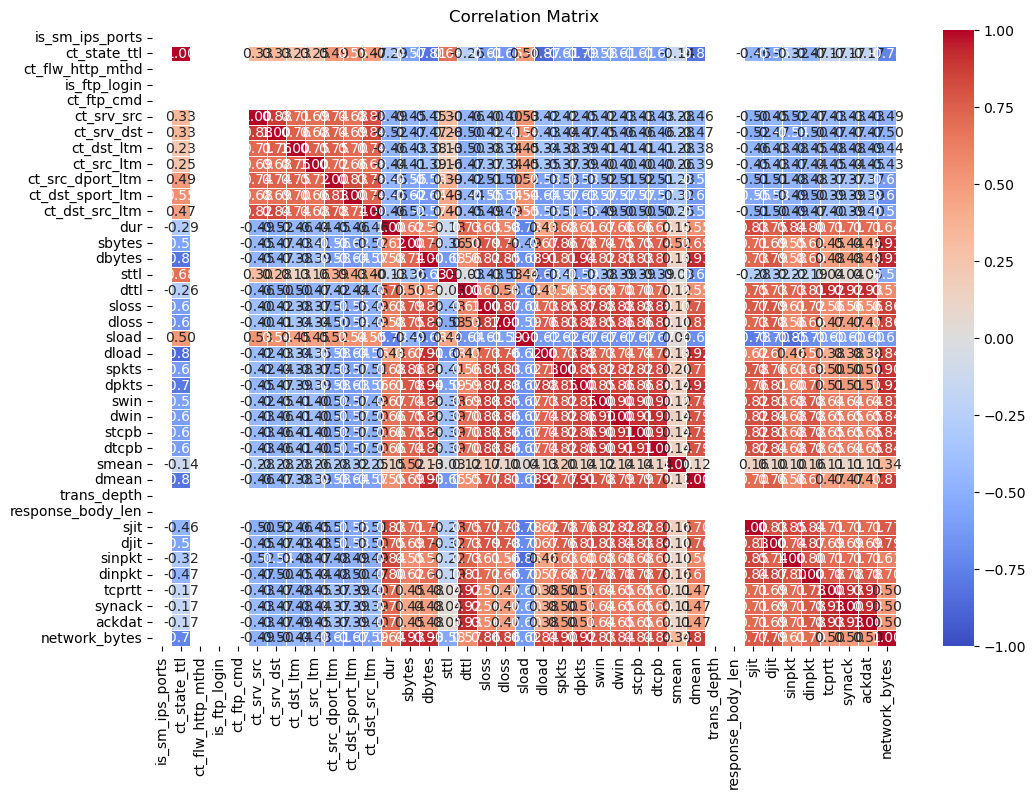

In [24]:
# Step 1: Compute the correlation matrix
correlation_matrix = train_set.corr()

# Step 2: Plot the correlation matrix
plt.figure(figsize=(12, 8))  # Set the size of the figure
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Step 3: Drop highly correlated features
# Create an upper triangle matrix (since correlation is symmetric, we need to check only one side)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Get columns with correlations higher than a threshold (e.g., 0.9)
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]

# Drop the highly correlated features
train_dropped = train_set.drop(columns=highly_correlated_features)

In [25]:
train_dropped

,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,state,...,dbytes,sttl,dttl,service,sload,smean,trans_depth,response_body_len,proto,attack_cat
11435,0.0,2.0,0.0,0.0,0.0,1.416768,1.247218,1.091523,1.497542,INT,...,-1.038789,254.0,0.0,dns,0.839367,-0.826033,0.0,0.0,udp,Generic
163811,0.0,2.0,0.0,0.0,0.0,0.368986,0.137964,0.724511,0.658348,INT,...,-1.038789,254.0,0.0,-,1.235381,0.639320,0.0,0.0,unas,Backdoor
128511,0.0,2.0,0.0,0.0,0.0,0.687675,1.117736,0.839239,1.370543,INT,...,-1.038789,254.0,0.0,-,1.632200,0.434269,0.0,0.0,nvp,DoS
141200,0.0,2.0,0.0,0.0,0.0,1.567517,1.344283,1.211905,1.549669,INT,...,-1.038789,254.0,0.0,dns,-0.174829,-0.059002,0.0,0.0,udp,Generic
126356,0.0,2.0,0.0,0.0,0.0,-1.411576,-1.168586,-1.318432,-0.817052,INT,...,-1.038789,254.0,0.0,-,1.610122,0.285199,0.0,0.0,udp,Reconnaissance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95939,0.0,1.0,0.0,0.0,0.0,-1.411576,-1.168586,-1.318432,-0.817052,FIN,...,1.743456,254.0,252.0,-,-1.067786,-0.214334,0.0,0.0,tcp,Exploits
152315,0.0,0.0,0.0,0.0,0.0,-0.433481,-0.327298,-0.114195,-0.817052,FIN,...,1.392318,31.0,29.0,-,-0.004148,-0.059002,0.0,0.0,tcp,Normal
117952,0.0,2.0,0.0,0.0,0.0,-1.411576,-0.327298,-1.318432,-0.817052,INT,...,-1.038789,254.0,0.0,-,1.117706,0.285199,0.0,0.0,udp,Reconnaissance
173685,0.0,2.0,0.0,0.0,0.0,1.609872,-0.327298,1.744530,1.718432,INT,...,-1.038789,254.0,0.0,dns,0.839367,-0.826033,0.0,0.0,udp,Generic


In [26]:
X = train_dropped.drop("attack_cat", axis = 1)
y = train_dropped["attack_cat"]

In [27]:
categorical_cols = ['state', 'service', 'proto']
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse_output=False), categorical_cols)], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [28]:
# smote = SMOTE(random_state=0)
# X_resampled, y_resampled = smote.fit_resample(X, y)

In [29]:
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold

In [30]:
var_threshold = 0.01
var_filter = VarianceThreshold(threshold=var_threshold)
X_train_filtered = var_filter.fit_transform(X)

In [31]:
X_train_filtered.shape

(140272, 30)

In [32]:
selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X_train_filtered, y)

In [33]:
X_selected.shape

(140272, 20)

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [35]:
power_transformer = PowerTransformer(method='yeo-johnson')  # You can also use 'box-cox' if all data is positive
X_power_transformed = power_transformer.fit_transform(X_scaled)

In [36]:
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import RandomForestClassifier  # Or any model of your choice

# # Initialize the model (e.g., RandomForest)
# model = RandomForestClassifier(random_state=42)

In [37]:
# rfe_selector = RFE(estimator=model, n_features_to_select=20)

# # Fit the RFE selector
# X_rfe_selected = rfe_selector.fit_transform(X, y)

# # Get the selected feature columns
# selected_columns_rfe = X.columns[rfe_selector.support_]

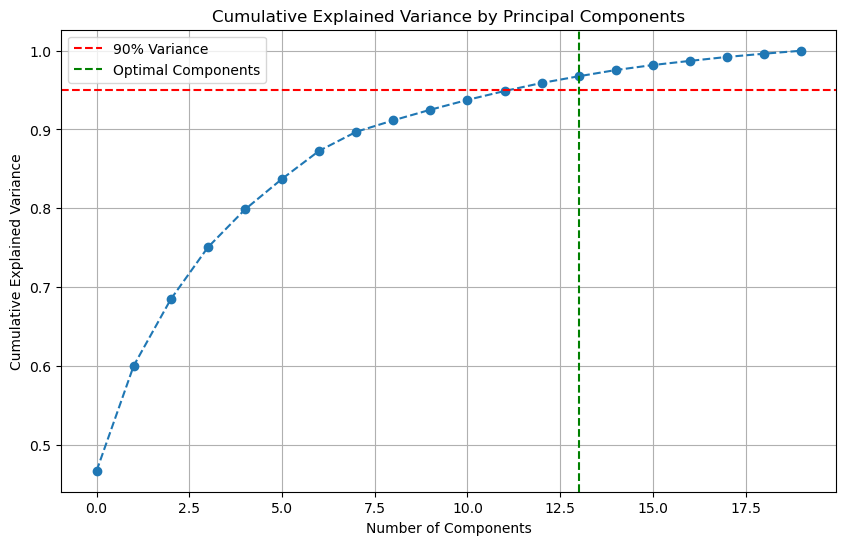

In [38]:
pca = PCA()
pca.fit(X_power_transformed)

# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

variance_threshold = 0.95

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=variance_threshold, color='r', linestyle='--', label='90% Variance')
plt.axvline(x=np.argmax(cumulative_variance >= variance_threshold) + 1, color='g', linestyle='--', label='Optimal Components')
plt.legend()
plt.grid()
plt.show()

In [39]:
optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1
print(f'Optimal number of components to retain 90% variance: {optimal_components}')

Optimal number of components to retain 90% variance: 13


In [40]:
pca = PCA(n_components=optimal_components)  # Retain 95% of variance
X_pca = pca.fit_transform(X_power_transformed)

In [41]:
X_pca.shape

(140272, 13)

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                    stratify=y)

In [43]:

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

smote = SMOTE(sampling_strategy='auto', k_neighbors=7, random_state=0)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)



In [44]:
# models = {
#     'Decision Tree': DecisionTreeClassifier(criterion="entropy"),
#     'KNN': KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
#     'Gaussian Naive Bayes': GaussianNB(),
# }

# f1_scores = {}

# # Train and evaluate each model
# for model_name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' as needed
#     f1_scores[model_name] = f1

# # Step 13: Display F1 Scores
# print("F1 Scores:")
# for model_name, score in f1_scores.items():
#     print(f"{model_name}: {score:.4f}")

In [45]:
# from sklearn.model_selection import cross_val_score, StratifiedKFold

# cv_scores = {}

# # Set up Stratified K-Fold cross-validation
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# # Evaluate each model using cross-validation
# for model_name, model in models.items():
#     scores = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='f1_weighted')
#     cv_scores[model_name] = scores
#     print(f"{model_name} Cross-Validation F1 Scores: {scores}")
#     print(f"{model_name} Mean F1 Score: {scores.mean():.4f} ± {scores.std():.4f}")

# # Optionally, you can also find the best model based on mean F1 score
# best_model_name = max(cv_scores, key=lambda k: cv_scores[k].mean())
# print(f"Best Model: {best_model_name} with Mean F1 Score: {cv_scores[best_model_name].mean():.4f}")

In [46]:
# from sklearn.model_selection import GridSearchCV

# dt_model = DecisionTreeClassifier()

# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Set up GridSearchCV
# grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, 
#                            scoring='f1_weighted', cv=5, n_jobs=-1)

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Best parameters and score
# print("Best parameters:", grid_search.best_params_)
# print("Best F1 Score:", grid_search.best_score_)

In [47]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train[:, 18:] = sc.fit_transform(X_train[:, 18:])
# X_test[:, 18:] = sc.transform(X_test[:, 18:])

In [48]:
from sklearn.metrics import classification_report, accuracy_score

In [49]:
# k_values = range(1, 21)
# mean_scores = []

# # Perform cross-validation for each k
# for k in k_values:
#     knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
#     scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
#     mean_scores.append(scores.mean())

# # Plotting the results
# plt.figure(figsize=(10, 6))
# plt.plot(k_values, mean_scores, marker='o')
# plt.title('KNN Classifier Accuracy vs. Number of Neighbors')
# plt.xlabel('Number of Neighbors (k)')
# plt.ylabel('Mean Accuracy')
# plt.xticks(k_values)
# plt.grid()
# plt.show()

# # Determine the optimal k
# optimal_k = k_values[np.argmax(mean_scores)]
# print(f'Optimal number of neighbors (k): {optimal_k}')


optimal_k = 15

In [50]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=optimal_k, metric='euclidean')

knn.fit(X_train_res, y_train_res)
knn_pred = knn.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, knn_pred))
print("Classification Report: \n", classification_report(y_test, knn_pred))

Accuracy:  0.7386918552842631
Classification Report: 
                 precision    recall  f1-score   support

      Analysis       0.11      0.32      0.17       326
      Backdoor       0.08      0.17      0.11       280
           DoS       0.31      0.42      0.36      1961
      Exploits       0.70      0.51      0.59      5342
       Fuzzers       0.57      0.75      0.65      2910
       Generic       1.00      0.98      0.99      6395
        Normal       0.98      0.81      0.89      8950
Reconnaissance       0.66      0.73      0.70      1684
     Shellcode       0.23      0.62      0.34       185
         Worms       0.06      0.41      0.11        22

      accuracy                           0.74     28055
     macro avg       0.47      0.57      0.49     28055
  weighted avg       0.80      0.74      0.76     28055



In [51]:
# from main import KNNScratch

# knn_scratch = KNNScratch(neighbors=5, metric='euclidean')
# knn_scratch.fit(X_train, y_train)
# knn_scratch_pred = knn_scratch.predict(X_test)
# print("Accuracy: ", accuracy_score(y_test, knn_scratch_pred))
# print("Classification Report: \n", classification_report(y_test, knn_scratch_pred))

In [52]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_res, y_train_res)
gnb_pred = gnb.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, gnb_pred))
print("Classification Report: \n", classification_report(y_test, gnb_pred))

Accuracy:  0.6004633755123864
Classification Report: 
                 precision    recall  f1-score   support

      Analysis       0.05      0.31      0.09       326
      Backdoor       0.06      0.31      0.09       280
           DoS       0.30      0.16      0.21      1961
      Exploits       0.64      0.33      0.43      5342
       Fuzzers       0.46      0.56      0.50      2910
       Generic       1.00      0.95      0.97      6395
        Normal       0.93      0.74      0.82      8950
Reconnaissance       0.39      0.10      0.16      1684
     Shellcode       0.06      0.58      0.12       185
         Worms       0.01      0.59      0.01        22

      accuracy                           0.60     28055
     macro avg       0.39      0.46      0.34     28055
  weighted avg       0.74      0.60      0.65     28055



In [53]:
# from main import GaussianNaiveBayesScratch

# gnb_scratch = GaussianNaiveBayesScratch()
# gnb_scratch.fit(X_train, y_train)
# gnb_scratch_pred = gnb_scratch.predict(X_test)
# print("Accuracy: ", accuracy_score(y_test, gnb_scratch_pred))
# print("Classification Report: \n", classification_report(y_test, gnb_scratch_pred))

In [54]:
# smote = SMOTE(random_state=0)

# # Fit and resample the training data
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [55]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion="entropy")
dt.fit(X_train_res, y_train_res)
dt_pred = dt.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, dt_pred))
print("Classification Report: \n", classification_report(y_test, dt_pred))

Accuracy:  0.7384067011227945
Classification Report: 
                 precision    recall  f1-score   support

      Analysis       0.12      0.17      0.14       326
      Backdoor       0.07      0.11      0.08       280
           DoS       0.28      0.39      0.33      1961
      Exploits       0.64      0.54      0.59      5342
       Fuzzers       0.58      0.60      0.59      2910
       Generic       0.99      0.98      0.98      6395
        Normal       0.91      0.86      0.88      8950
Reconnaissance       0.71      0.69      0.70      1684
     Shellcode       0.24      0.48      0.32       185
         Worms       0.12      0.36      0.18        22

      accuracy                           0.74     28055
     macro avg       0.46      0.52      0.48     28055
  weighted avg       0.76      0.74      0.75     28055



In [56]:
# from sklearn.model_selection import KFold, cross_val_score

# # Set up k-fold cross-validation
# k = 5  # You can change this to any number of folds you prefer
# kf = KFold(n_splits=k, shuffle=True, random_state=0)

# # Perform cross-validation
# cv_scores = cross_val_score(dt, X, y, cv=kf)

# # Print the results
# print(f"Cross-Validation Scores: {cv_scores}")
# print(f"Mean CV Score: {np.mean(cv_scores)}")
# print(f"Standard Deviation of CV Scores: {np.std(cv_scores)}")

In [57]:
# from main import DecisionTreeClassifierScratch

# dt_scratch = DecisionTreeClassifierScratch()
# dt_scratch.fit(X_train, y_train)
# dt_scratch_pred = dt_scratch.predict(X_test)
# print("Accuracy: ", accuracy_score(y_test, dt_scratch_pred))
# print("Classification Report: \n", classification_report(y_test, dt_scratch_pred))